# Week - 8 - Deep Neural Nets and Text - Training Models

## Exercise 1
Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

***Stretch***: Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

In [6]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [8]:
!pip install transformers

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [0]:
negDF = pd.read_csv('comments_negative.csv', nrows=5000)
posDF = pd.read_csv('comments_positive.csv', nrows=5000)

In [10]:
df = pd.concat([posDF[['text']], negDF[['text']]], axis=0, ignore_index=True)
df['label'] = [1] * 5000 + [0] * 5000
df

,text,label
0,This isn't Twitter: try to comment on the arti...,1
1,"Well, it is exactly what it sounds like. It's ...",1
2,"In soviet Russia, bomb disarms you!",1
3,"""runin for senitur! #YOLO!""",1
4,You step motherfucker.,1
...,...,...
9995,Devil's advocate here for sake of argument. W...,0
9996,Are you reading with your ears? xD Hes talking...,0
9997,Gay man here who visits TRP decently often: i...,0
9998,PSY,0


In [0]:
# Create sentence and label lists
com_sentences = df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
com_sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in com_sentences]
labels = df.label.values

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in com_sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'this', 'isn', "'", 't', 'twitter', ':', 'try', 'to', 'comment', 'on', 'the', 'article', ',', 'and', 'not', 'your', 'current', 'activities', '.', '[SEP]']


In [0]:
MAX_LEN = 128

In [0]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [15]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

### Deep Neural Nets

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [0]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [21]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           976704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [22]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





9000/9000 [==============================] - 84s 9ms/step - loss: 0.6934 - acc: 0.5004
Epoch 2/10
9000/9000 [==============================] - 76s 8ms/step - loss: 0.6924 - acc: 0.5043
Epoch 3/10
9000/9000 [==============================] - 78s 9ms/step - loss: 0.6901 - acc: 0.5199
Epoch 4/10
9000/9000 [==============================] - 76s 8ms/step - loss: 0.6752 - acc: 0.5258
Epoch 5/10
9000/9000 [==============================] - 74s 8ms/step - loss: 0.6560 - acc: 0.5396
Epoch 6/10
9000/9000 [==============================] - 72s 8ms/step - loss: 0.6460 - acc: 0.5406
Epoch 7/10
9000/9000 [==============================] - 72s 8ms/step - loss: 0.6424 - acc: 0.5354
Epoch 8/10
9000/9000 [==============================] - 72s 8ms/step - loss: 0.6430 - acc: 0.5341
Epoch 9/10
9000/9000 [==============================] - 71s 8ms/step - loss: 0.6427 - acc: 0.5300
Epoch 10/10
9000

The general LSTM model does not perform well on our dataset, with an accuracy rate at around 54%. I add another LSTM layer and change the type losses.

In [35]:
units = 150
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm2.add(LSTM(units, return_sequences=True))
model_lstm2.add(LSTM(units))
model_lstm2.add(Dense(1, activation='sigmoid'))
model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm2 = model_lstm2.fit(train_inputs, train_labels, epochs=10, batch_size=batch_size)

Epoch 1/10
9000/9000 [==============================] - 145s 16ms/step - loss: 0.6934 - acc: 0.4971
Epoch 2/10
9000/9000 [==============================] - 142s 16ms/step - loss: 0.6932 - acc: 0.5068
Epoch 3/10
9000/9000 [==============================] - 146s 16ms/step - loss: 0.6794 - acc: 0.5263
Epoch 4/10
9000/9000 [==============================] - 147s 16ms/step - loss: 0.6510 - acc: 0.5360
Epoch 5/10
9000/9000 [==============================] - 147s 16ms/step - loss: 0.6425 - acc: 0.5486
Epoch 6/10
9000/9000 [==============================] - 147s 16ms/step - loss: 0.6352 - acc: 0.5443
Epoch 7/10
9000/9000 [==============================] - 143s 16ms/step - loss: 0.6330 - acc: 0.5528
Epoch 8/10
9000/9000 [==============================] - 142s 16ms/step - loss: 0.6275 - acc: 0.5628
Epoch 9/10
9000/9000 [==============================] - 143s 16ms/step - loss: 0.6390 - acc: 0.5529
Epoch 10/10
9000/9000 [==============================] - 142s 16ms/step - loss: 0.6508 - acc: 0.5434

Adding one more layer of LSTM and using binary cross entropy as losses, our accuracy rate is still around 56%.

### On with BERT!

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [26]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:49.
  Batch    80  of    282.    Elapsed: 0:01:38.
  Batch   120  of    282.    Elapsed: 0:02:27.
  Batch   160  of    282.    Elapsed: 0:03:16.
  Batch   200  of    282.    Elapsed: 0:04:05.
  Batch   240  of    282.    Elapsed: 0:04:55.
  Batch   280  of    282.    Elapsed: 0:05:45.

  Average training loss: 0.56
  Training epcoh took: 0:05:46

Running Validation...
  Accuracy: 0.76
  Validation took: 0:00:14

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:50.
  Batch    80  of    282.    Elapsed: 0:01:40.
  Batch   120  of    282.    Elapsed: 0:02:29.
  Batch   160  of    282.    Elapsed: 0:03:19.
  Batch   200  of    282.    Elapsed: 0:04:09.
  Batch   240  of    282.    Elapsed: 0:04:59.
  Batch   280  of    282.    Elapsed: 0:05:49.

  Average training loss: 0.40
  Training epcoh took: 0:05:50

Running Validation...
  Accuracy: 0.78
  Validation took: 0:00:1

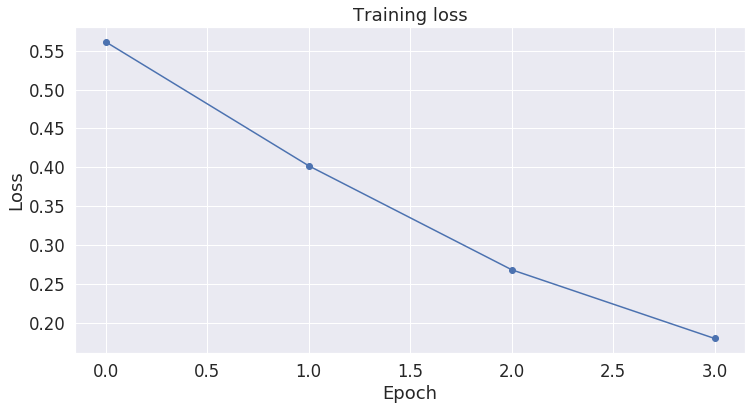

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

The BERT model performs much better than LSTM, with an accuracy rate at 79%. From the graph above, we can see that as epoch number increases, average training loss decreases.

### Holdout Set

In [0]:
negPred = pd.read_csv('comments_negative.csv', nrows=10000)[5000:]
posPred = pd.read_csv('comments_positive.csv', nrows=10000)[5000:]

In [38]:
dfPred = pd.concat([posPred[['text']], negPred[['text']]], axis=0, ignore_index=True)
dfPred['label'] = [1] * 5000 + [0] * 5000
dfPred

,text,label
0,lol wat.\n\nWake up owner please! OMNOMONOMNOM...,1
1,The groom is wearing a white dress shirt with ...,1
2,*sigh* Okay...\n\nWhen I was a freshman in col...,1
3,"Due to hormones, that isn't supposed to happen...",1
4,Why not? You eat everyone else's,1
...,...,...
9995,Ultima Online,0
9996,Hey.,0
9997,Gay people deserve equal rights.,0
9998,I'll save you some time: It's the part that sa...,0


In [39]:
# Create sentence and label lists
sentences = dfPred.text.values
labels = dfPred.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (868 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1420 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [40]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10,000 test sentences...
    DONE.


In [41]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 5000 of 10000 (50.00%)


In [42]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [43]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.520


The model has pretty good performance, suggesting that there is a strong positive relationship between the actual label and the predicted label. The Google Bert model also has a similar score. These two models performed much better than the LSTM model.

## Exercise 2
In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

### Embeddings, Context Words

In [0]:
parDF = pd.concat([posDF[['text', 'parent_text']], negDF[['text', 'parent_text']]], axis=0, ignore_index=True)
text = parDF.text
par_text = parDF.parent_text
text = ["[CLS] " + sentence + " [SEP]" for sentence in text]
par_text = ["[CLS] " + sentence + " [SEP]" for sentence in par_text]

In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize our sentence with the BERT tokenizer.
tokenized_text = [tokenizer.tokenize(com) for com in text]
tokenized_par = [tokenizer.tokenize(par_com) for par_com in par_text]

# Print out the tokens.
print(tokenized_text[0])
print(tokenized_par[0])

['[CLS]', 'this', 'isn', "'", 't', 'twitter', ':', 'try', 'to', 'comment', 'on', 'the', 'article', ',', 'and', 'not', 'your', 'current', 'activities', '.', '[SEP]']
['[CLS]', 'fucking', 'fa', '##gg', '##ot', '.', '[SEP]']


In [0]:
# Map the token strings to their vocabulary indeces.
indexed_text = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_text]
indexed_par = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_par]

In [0]:
indexed_text = pad_sequences(indexed_text, maxlen=128, dtype="long", truncating="post", padding="post")
indexed_par = pad_sequences(indexed_par, maxlen=128, dtype="long", truncating="post", padding="post")

### Segment ID

In [0]:
text_ids = [128 * [1] for index in tokenized_text]
par_ids = [128 * [1] for index in tokenized_par]

In [0]:
text_token_tensor = torch.tensor(indexed_text[:50])
par_token_tensor = torch.tensor(indexed_par[:50])
text_seg_tensor = torch.tensor(text_ids[:50])
par_seg_tensor = torch.tensor(par_ids[:50])

In [50]:
# Load pre-trained model (weights)
from transformers import BertModel
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [0]:
output = model_embedding(text_token_tensor, text_seg_tensor)
par_output = model_embedding(par_token_tensor, par_seg_tensor)

### Understanding the Output

In [0]:
word_embeddings, sentence_embedding = output
word_embeddings_par, sentence_embedding_par = par_output

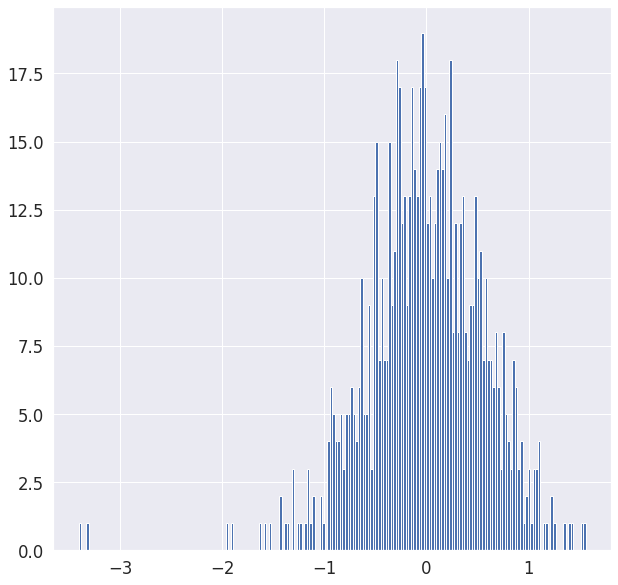

In [53]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

The range is fairly similar for all layers and tokens, with the majority of values falling between [-1, 1].

### Sentence Vector

In [0]:
from scipy.spatial.distance import cosine
l = len(sentence_embedding.detach().numpy())
embedding_cosine = [1 - cosine(sentence_embedding[i].detach().numpy(), sentence_embedding_par[i].detach().numpy()) for i in range(l)]

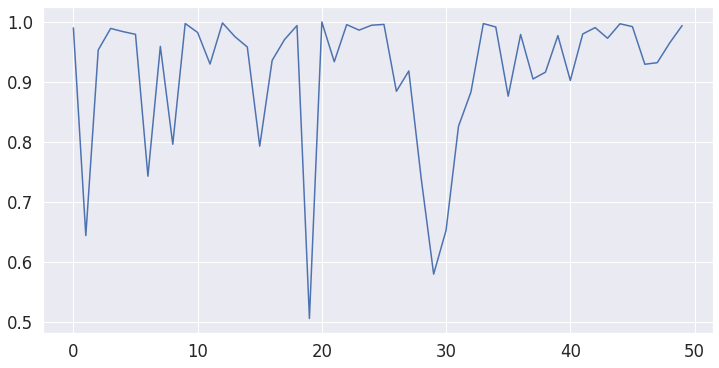

In [55]:
plt.plot(embedding_cosine)

The cosine similarity of sentence embeddings between comments and parent comments is high for all token tensers except 1 at around 19. Three other places have similarities at around 0.6-0.7, and all the other places obtained a similarity above 0.8. This suggests that comments and parent comments are highly similar in their embeddings.

### Transformers Pipelines

In [56]:
from transformers import pipeline
# Allocate a pipeline for sentiment-analysis
nlp_sentiment = pipeline('sentiment-analysis')

In [0]:
com_sentiment = [nlp_sentiment(text) for text in parDF.text[:1000]]
par_sentiment = [nlp_sentiment(text) for text in parDF.parent_text[:1000]]

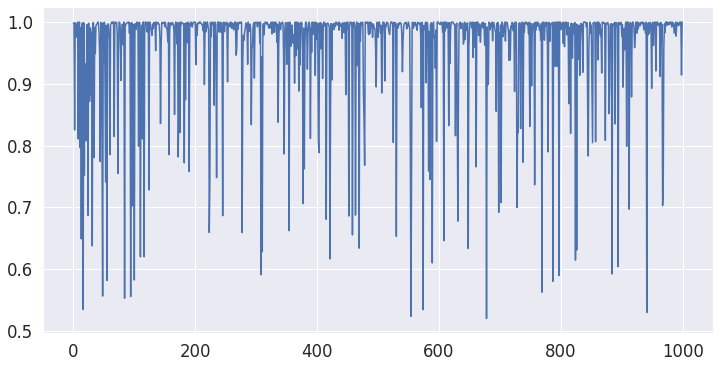

In [58]:
com_s = []
for i in range(len(com_sentiment)):
  com_s.append(com_sentiment[i][0]['score'])
plt.plot(com_s)

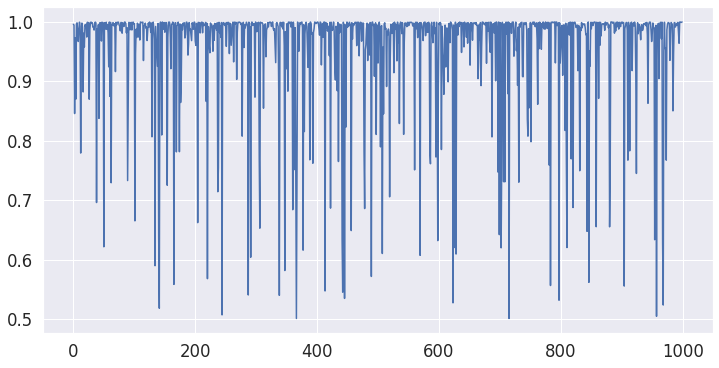

In [59]:
par_s = []
for i in range(len(par_sentiment)):
  par_s.append(par_sentiment[i][0]['score'])
plt.plot(par_s)

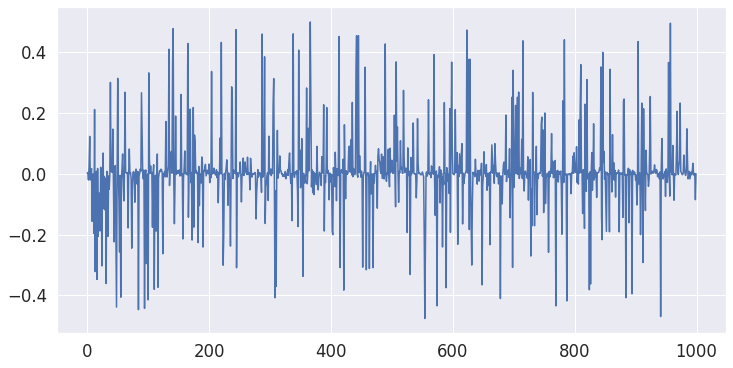

In [60]:
diff = []
for i in range(len(com_s)):
  diff.append(com_s[i] - par_s[i])
plt.plot(diff)

Most of the sentiment differences are within 0.5, suggesting that comments and parent comments are similar in sentiments. Looking at the sentiment scores of comments and parent comments individually, all of them have sentiment scores above 0.5. This is a quite surprising fact for comments online, especially that we combined comments that obtained both high upvotes and high downvotes.

## Exercise 3
Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [0]:
torch.cuda.empty_cache() 

First, I trained the model using a dataset that contains comments that receive the highest upvotes.

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(posDF['text'], test_size=0.2)

In [63]:
train_text.head()

3107                        Stretching in my seat? Boner.
685     Selfie sticks are probably the least weird thi...
2609    Everyone knows A negatives grow cabbages at th...
2198    That's a bit like asking 'how do fish get into...
1499    But hey, torturing and killing people on TV? N...
Name: text, dtype: object

In [0]:
train_text.to_frame().to_csv(r'train_text', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text', header=None, index=None, sep=' ', mode='a')

In [65]:
!python run_language_modelling.py --output_dir=output_gpt_text --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text --do_eval --eval_data_file=test_text --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

03/07/2020 21:11:52 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/07/2020 21:11:52 - INFO - filelock -   Lock 140306645543736 acquired on /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942.lock
03/07/2020 21:11:52 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpvsz7rwrg
Downloading: 100% 224/224 [00:00<00:00, 196kB/s]
03/07/2020 21:11:52 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json in cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
03/07/2020 21:11:52 - INFO

In [66]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_text

03/07/2020 21:20:47 - INFO - transformers.tokenization_utils -   Model name 'output_gpt_text' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'output_gpt_text' is a path, a model identifier, or url to a directory containing tokenizer files.
03/07/2020 21:20:47 - INFO - transformers.tokenization_utils -   Didn't find file output_gpt_text/added_tokens.json. We won't load it.
03/07/2020 21:20:47 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/vocab.json
03/07/2020 21:20:47 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/merges.txt
03/07/2020 21:20:47 - INFO - transformers.tokenization_utils -   loading file None
03/07/2020 21:20:47 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/special_tokens_map.json
03/07/2020 21:20:47 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/tokenizer_config.json
03/07/2020 21:20:47 - INFO - transformers.co

This is really interesting! This suggests that comments in our dataset (highest upvotes) might express negative attitudes towards the country.

In [0]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

tokenizer_comment = AutoTokenizer.from_pretrained("output_gpt_text")
model_comment = AutoModelWithLMHead.from_pretrained("output_gpt_text")

In [89]:
sequence = "i am"

input = tokenizer_comment.encode(sequence, return_tensors="pt")
generated = model_comment.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_comment.decode(generated.tolist()[0])
print(resulting_string)

i am an atheist, you see.. but you have never told me what I'm actually saying?"
"


In [86]:
sequence = "you are"

input = tokenizer_comment.encode(sequence, return_tensors="pt")
generated = model_comment.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_comment.decode(generated.tolist()[0])
print(resulting_string)

you are not a black person and you just want to be treated as such"


I'm impressed by the quality of the generated text. The text makes a lot of sense, ands since Reddit comments are short by nature, these generated text are short as well. In addition, these expressions are colloquial and the topics are very much like what we usually see in online conversation. 

## Exercise 4
Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

In [0]:
train_text, test_text = train_test_split(negDF['text'], test_size=0.2)
train_text.to_frame().to_csv(r'train_neg', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_neg', header=None, index=None, sep=' ', mode='a')

First, I trained models using the dataset that contains comments that receive the highest downvotes.

In [91]:
!python run_language_modelling.py --output_dir=output_gpt_neg --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_neg --do_eval --eval_data_file=test_neg --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

03/07/2020 21:27:10 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/07/2020 21:27:10 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
03/07/2020 21:27:10 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20

In [92]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_neg

03/07/2020 21:30:17 - INFO - transformers.tokenization_utils -   Model name 'output_gpt_neg' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'output_gpt_neg' is a path, a model identifier, or url to a directory containing tokenizer files.
03/07/2020 21:30:17 - INFO - transformers.tokenization_utils -   Didn't find file output_gpt_neg/added_tokens.json. We won't load it.
03/07/2020 21:30:17 - INFO - transformers.tokenization_utils -   loading file output_gpt_neg/vocab.json
03/07/2020 21:30:17 - INFO - transformers.tokenization_utils -   loading file output_gpt_neg/merges.txt
03/07/2020 21:30:17 - INFO - transformers.tokenization_utils -   loading file None
03/07/2020 21:30:17 - INFO - transformers.tokenization_utils -   loading file output_gpt_neg/special_tokens_map.json
03/07/2020 21:30:17 - INFO - transformers.tokenization_utils -   loading file output_gpt_neg/tokenizer_config.json
03/07/2020 21:30:17 - INFO - transformers.configura

In [0]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
com_model_embedding = RobertaModel.from_pretrained('output_gpt_text')
com_tokenizer = RobertaTokenizer.from_pretrained('output_gpt_text')

In [0]:
import seaborn as sns
from scipy.spatial.distance import cosine
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

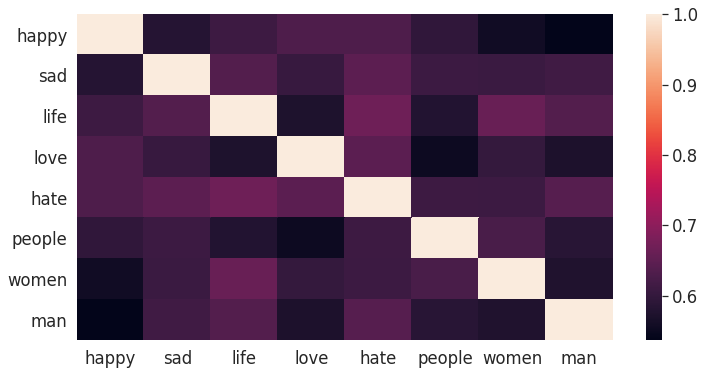

In [96]:
text = "happy sad life love hate people women man" 
visualise_diffs(text, com_model_embedding, com_tokenizer)

In [0]:
neg_model_embedding = RobertaModel.from_pretrained('output_gpt_neg')
neg_tokenizer = RobertaTokenizer.from_pretrained('output_gpt_neg')

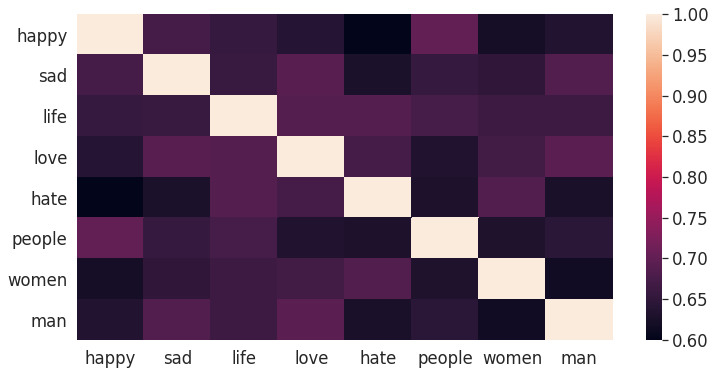

In [98]:
visualise_diffs(text, neg_model_embedding, neg_tokenizer)

Our two models are respectively trained from comments that received the highest 5000 upvotes and those that received the highest 5000 downvotes. Judging from the similarity heatmap, we cannot tell the difference between the similarities between these keywords in the two dataset. In addition, the similarities between keywords are not high - the similarity rate being around 0.6-0.7. This suggests that these words occur frequently in both types of comments and the model cannot distinguish between these words trained from different datasets. This is not surprising since the upvotes and downvotes received by the comments hardly depend on these keywords. 